In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/FYP"

/content/gdrive/MyDrive/FYP


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from PIL import Image
from torchsummary import summary

1. Class Radiography Dataset

In [ ]:
class RadiographyDataset(Dataset):

    def __init__(self, root, transform=None):
        super().__init__()
        self.data = []
        self.labels = []
        self.transform = transform
        #self.classes = ['Normal', 'COVID', 'Viral Pneumonia']

        self.classes   = os.listdir(root)
        # self.filenames = []
        # self.labels    = []

        # for i in range(len(self.classes)):
              # path = ps.join(root, self.classes[i])
              # for filename in os.listdir(path):
                  # filename = os.path.join(path, filename)
                  # self.filenames.append(filename)
                  # self.labels.append[i]

        #get the training samples
        for class_id, cls in enumerate(self.classes):

          cls_folder = os.path.join(root, cls)

          #get the training samples for the class 'cls'
          for img_name in os.listdir(cls_folder):
            self.data.append(os.path.join(cls_folder, img_name))
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # get the image
        image = Image.open(self.data[idx])
        image = image.convert('RGB')
        
        # perform transformation
        if self.transform is not None:
          image = self.transform(image)
        
        # get the label
        label = self.labels[idx]
        
        return image, label

2. Create a customizable BLOCK module

In [ ]:
class BLOCK(nn.Module):

    # ... define the init layer ...
    def __init__(self, blk_cin, blk_cout):

        super().__init__()

        # ... define the convolutional layers ... 
        self.conv1 = nn.Conv2d(blk_cin, blk_cout, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(blk_cout, blk_cout, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        # ...  forward propagation ... 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ... define block 1 ...
        self.conv_block1 = BLOCK(3, 32)
        
        # ... define block 2 ...
        self.conv_block2 = BLOCK(32, 64)

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))        

        self.fc1 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        # ... block 1 ...
        x = self.conv_block1(x)

        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        
        # ... block 2 ...
        x = self.conv_block2(x)

        # global pool
        x = self.global_pool(x)

        # view
        x = x.view(x.size(0), -1) 

        # fc1
        x = self.fc1(x)
        
        return x

3. Train the model

In [ ]:
if not os.path.exists("./custom_models"):
  os.mkdir("custom_models") 

In [ ]:
def train(model, trainloader, num_epochs, lr=0.1, momentum=0.9):
    
    if torch.cuda.is_available():
      device = torch.device("cuda")
      
    else:
      device = torch.device("cpu")

    loss_iterations = int(np.ceil(len(trainloader)/3))
    
    # transfer model to GPU
    model = model.to(device)
    
    # set the optimizer. Use the SGD optimizer. Use the lr and momentum settings passed by the user
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    # set to training mode
    model.train()

    # variables
    best_loss = np.inf
    saturate_count = 0
    
    # train the network
    for e in range(num_epochs):    

        running_loss = 0
        running_count = 0

        # for all batch samples
        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to zero
            optimizer.zero_grad()

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get gradients of all parameters
            loss.backward()

            # update parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

             # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                train_loss = running_loss / running_count
                running_loss = 0. 
                running_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

        # save the model       
        checkpoint_file = './custom_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)       
                
    print("Training completed.")

4. Evaluate the model

In [ ]:
def evaluate(net, testloader):

    # set to evaluation mode
    net.eval() 

    # running_correct
    running_corrects = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()

        # # disable gradient computation
        with torch.no_grad():
            
            # perform inference
            outputs = net(inputs)

            # predict as the best result  
            _, predicted = torch.max(outputs, 1)

            running_corrects += (targets == predicted).double().sum()


    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))

Check the dataset images number

In [ ]:
print('Total of original datasets         : ', len(os.listdir('./COVID-19_Radiography_Dataset/COVID/images')) + len(os.listdir('./COVID-19_Radiography_Dataset/Normal/images')) + len(os.listdir('./COVID-19_Radiography_Dataset/Viral Pneumonia/images')))
print('---------------------------------------------\n')

print('Train-Covid                        : ', len(os.listdir('./Radiography_Data/train/COVID')))
print('Train-Normal                       : ', len(os.listdir('./Radiography_Data/train/Normal')))
print('Train-Viral Pneumonia              : ', len(os.listdir('./Radiography_Data/train/Viral Pneumonia')))

print('\nValidation-Covid                   : ', len(os.listdir('./Radiography_Data/val/COVID')))
print('Validation-Normal                  : ', len(os.listdir('./Radiography_Data/val/Normal')))
print('Validation-Viral Pneumonia         : ', len(os.listdir('./Radiography_Data/val/Viral Pneumonia')))

print('\nTest-Covid                         : ', len(os.listdir('./Radiography_Data/test/COVID')))
print('Test-Normal                        : ', len(os.listdir('./Radiography_Data/test/Normal')))
print('Test-Viral Pneumonia               : ', len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

print('---------------------------------------------\n')
print('Total of Train, Val, Test datasets : ', len(os.listdir('./Radiography_Data/train/COVID')) + len(os.listdir('./Radiography_Data/train/Normal')) + len(os.listdir('./Radiography_Data/train/Viral Pneumonia')) +
      len(os.listdir('./Radiography_Data/val/COVID')) + len(os.listdir('./Radiography_Data/val/Normal')) + len(os.listdir('./Radiography_Data/val/Viral Pneumonia')) +
      len(os.listdir('./Radiography_Data/test/COVID')) + len(os.listdir('./Radiography_Data/test/Normal')) + len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

Total of original datasets         :  15153
---------------------------------------------

Train-Covid                        :  2892
Train-Normal                       :  8153
Train-Viral Pneumonia              :  1076

Validation-Covid                   :  362
Validation-Normal                  :  1019
Validation-Viral Pneumonia         :  134

Test-Covid                         :  362
Test-Normal                        :  1020
Test-Viral Pneumonia               :  135
---------------------------------------------

Total of Train, Val, Test datasets :  15153


Show the sample images

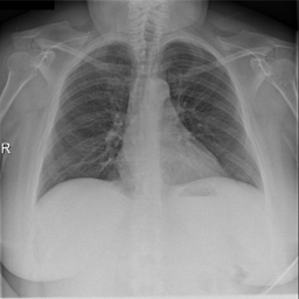

Class = COVID


In [ ]:
sampleset = RadiographyDataset("./Radiography_Data/train", transform=None)

image, label = sampleset[1]
display(image)
print("Class =", sampleset.classes[label])

The network layout

In [ ]:
sample_net = Net()
summary(sample_net, input_size=(3, 224,224))

RuntimeError: ignored

Transformation of images

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),                                # output: PIL Image of resolution(256, 256)
    transforms.RandomCrop(224),                            # output: PIL Image of resolution(224, 224)
    transforms.RandomHorizontalFlip(),                     # output: PIL Image of resolution(224, 224)
    transforms.ToTensor(),                                 # output: tensor, dtype = float32, shape = (3, 224, 224), range:[0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # output: same as before except range changes such that mean = 0, std = 1
])

#val_transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#])

Load the dataset using DataLoader

In [ ]:
#Load the dataset
trainset = RadiographyDataset("./Radiography_Data/train", transform=train_transform)
#valset  = RadiographyDataset("./Radiography_Data/val", transform=val_transform)

batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
#valloader  = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)

Start training

In [ ]:
net = Net()
train(net, trainloader, num_epochs=20, lr=0.1, momentum=0.9)

[Epoch  1 Iter    32/95]: train_loss = 1.1501
[Epoch  1 Iter    64/95]: train_loss = 0.8384
[Epoch  1 Iter    95/95]: train_loss = 0.8365
[Epoch  2 Iter    32/95]: train_loss = 0.8425
[Epoch  2 Iter    64/95]: train_loss = 0.8161
[Epoch  2 Iter    95/95]: train_loss = 0.8323
[Epoch  3 Iter    32/95]: train_loss = 0.8180
[Epoch  3 Iter    64/95]: train_loss = 0.8201
[Epoch  3 Iter    95/95]: train_loss = 0.8095
[Epoch  4 Iter    32/95]: train_loss = 0.8033
[Epoch  4 Iter    64/95]: train_loss = 0.8007
[Epoch  4 Iter    95/95]: train_loss = 0.7957
[Epoch  5 Iter    32/95]: train_loss = 0.7857
[Epoch  5 Iter    64/95]: train_loss = 0.7922
[Epoch  5 Iter    95/95]: train_loss = 0.7796
[Epoch  6 Iter    32/95]: train_loss = 0.7777
[Epoch  6 Iter    64/95]: train_loss = 0.7683
[Epoch  6 Iter    95/95]: train_loss = 0.7497
[Epoch  7 Iter    32/95]: train_loss = 0.7863
[Epoch  7 Iter    64/95]: train_loss = 0.7641
[Epoch  7 Iter    95/95]: train_loss = 0.7282
[Epoch  8 Iter    32/95]: train_lo

Evaluate model

In [ ]:
# transform the model
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
testset = RadiographyDataset("./Radiography_Data/val", transform=val_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
evaluate(net, testloader)

Accuracy = 71.35%
